<a href="https://colab.research.google.com/github/REICHIYAN/REI/blob/master/Turtle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File data found...reading GOOG data


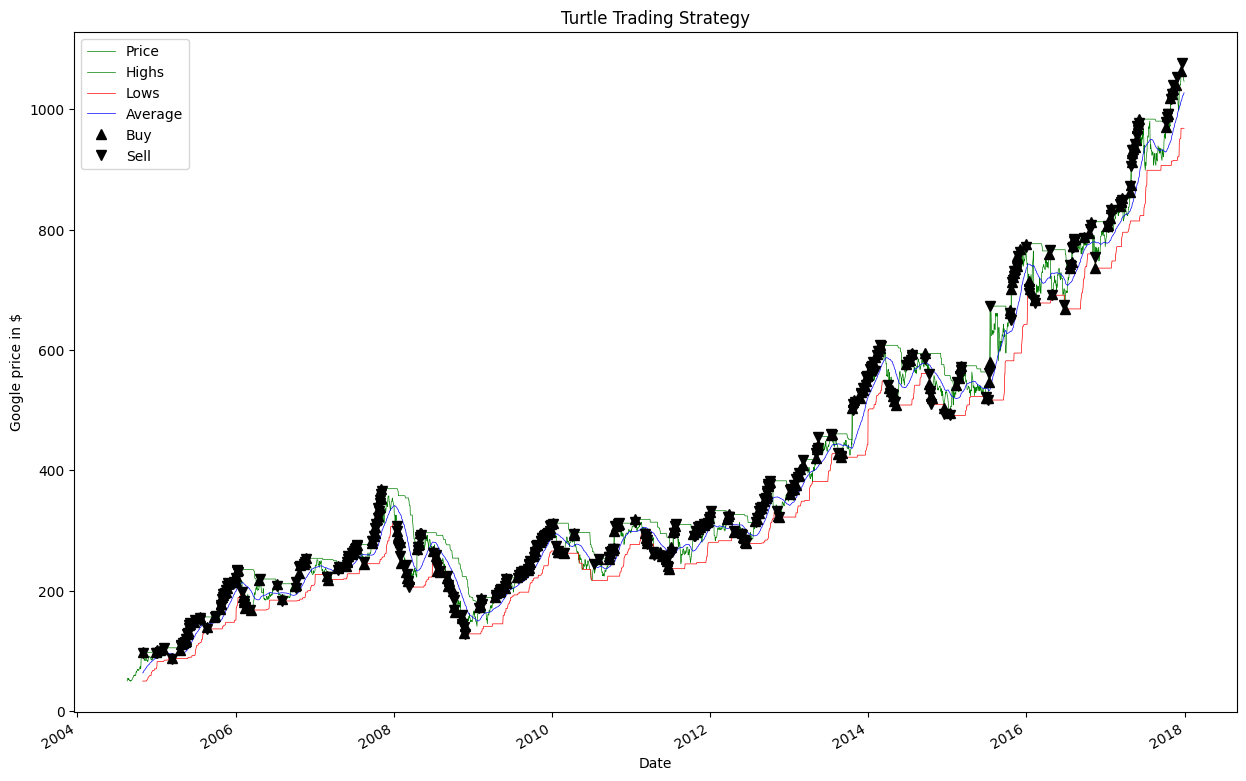

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
#!/bin/python3
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt

def load_financial_data(start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

goog_data=load_financial_data(start_date='2001-01-01',
                    end_date = '2018-01-01',
                    output_file='goog_data.pkl')



def turtle_trading(financial_data, window_size):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    # window_size-days high
    signals['high'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).max()
    # window_size-days low
    signals['low'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).min()
    # window_size-days mean
    signals['avg'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).mean()

    # entry rule : stock price > the higest value for window_size day
    #              stock price < the lowest value for window_size day

    signals['long_entry'] = financial_data['Adj Close'] > signals.high
    signals['short_entry'] = financial_data['Adj Close'] < signals.low

    #exit rule : the stock price crosses the mean of past window_size days.

    signals['long_exit'] = financial_data['Adj Close'] < signals.avg
    signals['short_exit'] = financial_data['Adj Close'] > signals.avg

    init=True
    position=0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position==0:
            signals.orders.values[k] = 1
            position=1
        elif signals['short_entry'][k] and position==0:
            signals.orders.values[k] = -1
            position=-1
        elif signals['short_exit'][k] and position>0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0

    return signals

ts=turtle_trading(goog_data, 50)

fig = plt.figure(figsize=(15,10),dpi=100)
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)


ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')


#
# ax1.plot(ts.loc[ts.long_entry== True].index,
#          goog_data["Adj Close"][ts.long_entry== True],
#          '^', markersize=7, color='k')
#
# ax1.plot(ts.loc[ts.short_entry== True].index,
#          goog_data["Adj Close"][ts.short_entry== True],
#          'v', markersize=7, color='k')
#
# ax1.plot(ts.loc[ts.long_exit == True].index,
#          goog_data["Adj Close"][ts.long_exit == True],
#          'v', markersize=7, color='k')
#
# ax1.plot(ts.loc[ts.short_exit == True].index,
#          goog_data["Adj Close"][ts.short_exit == True],
#          'v', markersize=7, color='k')


plt.legend(["Price","Highs","Lows","Average","Buy","Sell"])
plt.title("Turtle Trading Strategy")

plt.show()


import sys
sys.exit(0)

# You are going to set your initial amount of money you want
# to invest --- here it is 10,000
initial_capital = float(10000.0)

# You are going to create a new dataframe positions
# Remember the index is still the same as signals
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# You are going to buy 10 shares of MSFT when signal is 1
# You are going to sell 10 shares of MSFT when signal is -1
# You will assign these values to the column MSFT of the
# dataframe positions
positions['MSFT'] = 10 * signals['signal']

# You are now going to calculate the notional (quantity x price)
# for your portfolio. You will multiply Adj Close from
# the dataframe containing prices and the positions (10 shares)
# You will store it into the variable portfolio
portfolio = positions.multiply(financial_data['Adj Close'], axis=0)

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(financial_data['Adj Close'], axis=0)).sum(axis=1)

# You will store positions.diff into pos_diff
pos_diff = positions.diff()
# You will now add a column cash in your dataframe portfolio
# which will calculate the amount of cash you have
# initial_capital - (the notional you use for your different buy/sell)
portfolio['cash'] = initial_capital - (pos_diff.multiply(financial_data['Adj Close'], axis=0)).sum(axis=1).cumsum()

# You will now add a column total to your portfolio calculating the part of holding
# and the part of cash
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio)